In [52]:
import numpy as np
import sklearn
import pandas as pd

import matplotlib.ticker as mtick
from matplotlib import pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import requests
import folium

# Мои чипсы больше меня путешествуют :((
Начнем с очень краткого анализа стран, импортирующих в Россию. Самым простым параметром over time роста экспорта мне показалось брать коэффициент линейной регрессии (предварительно scaled данных). Перед вами очень краткая ячейка, о методологии которой мы еще успеем поговорить чуть дальше. Но пока что -- через какие страны едут мои Pringles из Польши?

In [53]:
X_to_RUSSIA = pd.read_csv('/TradeData_6_9_2024_3_1_54.csv', encoding='latin1') # Экспорт в Россию, 2022 год, выбранные европейские страны

XPgroup=X_to_RUSSIA.groupby(by='ReporterDesc')
coef_storage = XPgroup['PrimaryValue'].mean() # самый быстрый способ одномерного array с индектом стран, о котором я подумала

full = sorted(list(X_to_RUSSIA['ReporterDesc'].unique()))
# full is the list of countries used

for i in range(len(full)):
  if len(XPgroup.get_group(full[i]))>1: # пока не смотрим на полноту данных, а лишь на их валидность для регрессии
    avg = XPgroup.get_group(full[i])['PrimaryValue'].mean()
    Y_total = XPgroup.get_group(full[i])['PrimaryValue']/avg # scale к доли собственного среднего группы
    X_total = pd.DataFrame(XPgroup.get_group(full[i]), columns=['Period'])

    x_train, x_test, y_train, y_test = train_test_split(X_total, Y_total, test_size=0.1, random_state=340)
    # мы берем очень маленький размер теста, т.к. выборка небольшая и хочется видеть правдимые коэффициенты роста/падения
    LR = LinearRegression().fit(x_train, y_train)
    LR.predict(x_test)
    coef_storage.loc[full[i]] = LR.coef_[0]
  else:
    coef_storage.loc[full[i]] = 0

earth = requests.get(
    "https://raw.githubusercontent.com/python-visualization/folium-example-data/main/world_countries.json"
    ).json() # я карта я карта (красивая с границами)

m_x = folium.Map([50, 40], zoom_start=4)

folium.Choropleth(
    geo_data = earth,
    data = coef_storage,
    fill_opacit = 0.8,
    line_weight = 2,
    key_on = "feature.properties.name", # красивая карта не имеет в геодате id, поэтому обращаемся к ней по имени (поэтично)
    fill_color = "PRGn",
    bins = [-0.5, -0.3, -0.1, -0.05, 0, 0.05, 0.1, 0.3, 0.5],
).add_to(m_x)

m_x

Можем заметить интересный рост импорта из некоторых стран, граничащих с Россией -- а также Кыргызстана. Данных про Беларусь UN Comtrade имеет не так много, как мне хочется, поэтому для uniformity данных -- будем смотреть на две соседние страны -- Кыргызстан и Казахстан.

# Подготовка информации


UN Comtrade услужливо собирает дату в csv, однако только до 500 строк и с очень странными правилами поиска -- надо только на чутье полагаться, в каких параметрах "and", а в каких "or". Поэтому соберем данные за 2022 и 2023 отдельно, и сделаем concat.

Возникает еще одна проблема -- не все запрашиваемые страны имеют декларированный экспорт в Россию в 2023 году -- поэтому дополнительно уберем все такие страны. Список full нам пригодится еще чуть ниже -- не будем о нем забывать.

In [54]:
# 2022 monthly
X_to_KGZ2 = pd.read_csv('/TradeData_6_7_2024_15_8_51.csv', sep=',', encoding='latin1') # Экспорт в Кыргызстан
X_to_RUS2 = pd.read_csv('/TradeData_6_7_2024_15_11_24.csv', sep=',', encoding='latin1') # Экспорт в Россию
X_to_KAZ2 = pd.read_csv('/TradeData_6_7_2024_15_10_14.csv', sep=',', encoding='latin1') # Экспорт в Казахстан
# для удобства будем считать январь 2022 первым периодом (и для последующего scaling)
X_to_KGZ2['Period'] = X_to_KGZ2['Period'] - 202200
X_to_RUS2['Period'] = X_to_RUS2['Period'] - 202200
X_to_KAZ2['Period'] = X_to_KAZ2['Period'] - 202200
# 2023 monthly
X_to_KGZ3 = pd.read_csv('/TradeData_6_7_2024_15_12_50.csv', sep=',', encoding='latin1') # Экспорт в Кыргызстан
X_to_RUS3 = pd.read_csv('/TradeData_6_7_2024_15_12_6.csv', sep=',', encoding='latin1') # Экспорт в Россию
X_to_KAZ3 = pd.read_csv('/TradeData_6_7_2024_15_13_33.csv', sep=',', encoding='latin1') # Экспорт в Казахстан
# соотвественно для периодов 2023 года надо прибавить 12
X_to_KGZ3['Period'] = X_to_KGZ3['Period'] - 202300 + 12
X_to_RUS3['Period'] = X_to_RUS3['Period'] - 202300 + 12
X_to_KAZ3['Period'] = X_to_KAZ3['Period'] - 202300 + 12

X_to_KGZ = pd.concat([X_to_KGZ2, X_to_KGZ3], axis=0, ignore_index=True) # Экспорт в Кыргызстан за 2022 и 2023 -- you get the point
X_to_RUS = pd.concat([X_to_RUS2, X_to_RUS3], axis=0, ignore_index=True)
X_to_KAZ = pd.concat([X_to_KAZ2, X_to_KAZ3], axis=0, ignore_index=True)

full = sorted(list(X_to_KGZ3['ReporterDesc'].unique())) # т.к. потом группы будут сортить алфавитно страны для удобства

X_to_KGZ = X_to_KGZ.loc[X_to_KGZ['ReporterDesc'].isin(full)]
X_to_RUS = X_to_RUS.loc[X_to_RUS['ReporterDesc'].isin(full)]
X_to_KAZ = X_to_KAZ.loc[X_to_KAZ['ReporterDesc'].isin(full)]

X_to_KGZ2 = X_to_KGZ2.loc[X_to_KGZ2['ReporterDesc'].isin(full)]
X_to_RUS2 = X_to_RUS2.loc[X_to_RUS2['ReporterDesc'].isin(full)]
X_to_KAZ2 = X_to_KAZ2.loc[X_to_KAZ2['ReporterDesc'].isin(full)]

X_to_KGZ3 = X_to_KGZ3.loc[X_to_KGZ3['ReporterDesc'].isin(full)]
X_to_RUS3 = X_to_RUS3.loc[X_to_RUS3['ReporterDesc'].isin(full)]
X_to_KAZ3 = X_to_KAZ3.loc[X_to_KAZ3['ReporterDesc'].isin(full)]

Избавимся от ненужных колонок, полезной информации в которых замечено не было.

In [55]:
cols_tidy=['Period',
           'ReporterISO',
           'ReporterDesc',
           'ReporterCode',
           'PartnerISO',
           'PartnerDesc',
            'ClassificationCode',
           'PrimaryValue'
           ]

XP_to_KGZ = pd.DataFrame(X_to_KGZ, columns=cols_tidy)
XP_to_RUS = pd.DataFrame(X_to_RUS, columns=cols_tidy)
XP_to_KAZ = pd.DataFrame(X_to_KAZ, columns=cols_tidy)

# Визуализация (страшно)

## Primary Value куда-то растет (в Казахстан)

Первый способ визуализации -- на данные легче смотреть, если они в коробке. Для сравнения экспорта за 2022 и 2023 года в Казахстан и Россию используем удобные boxplots.

Группы отсортированы, а значит данные можно сравнимать между странами и годами по вертикали.

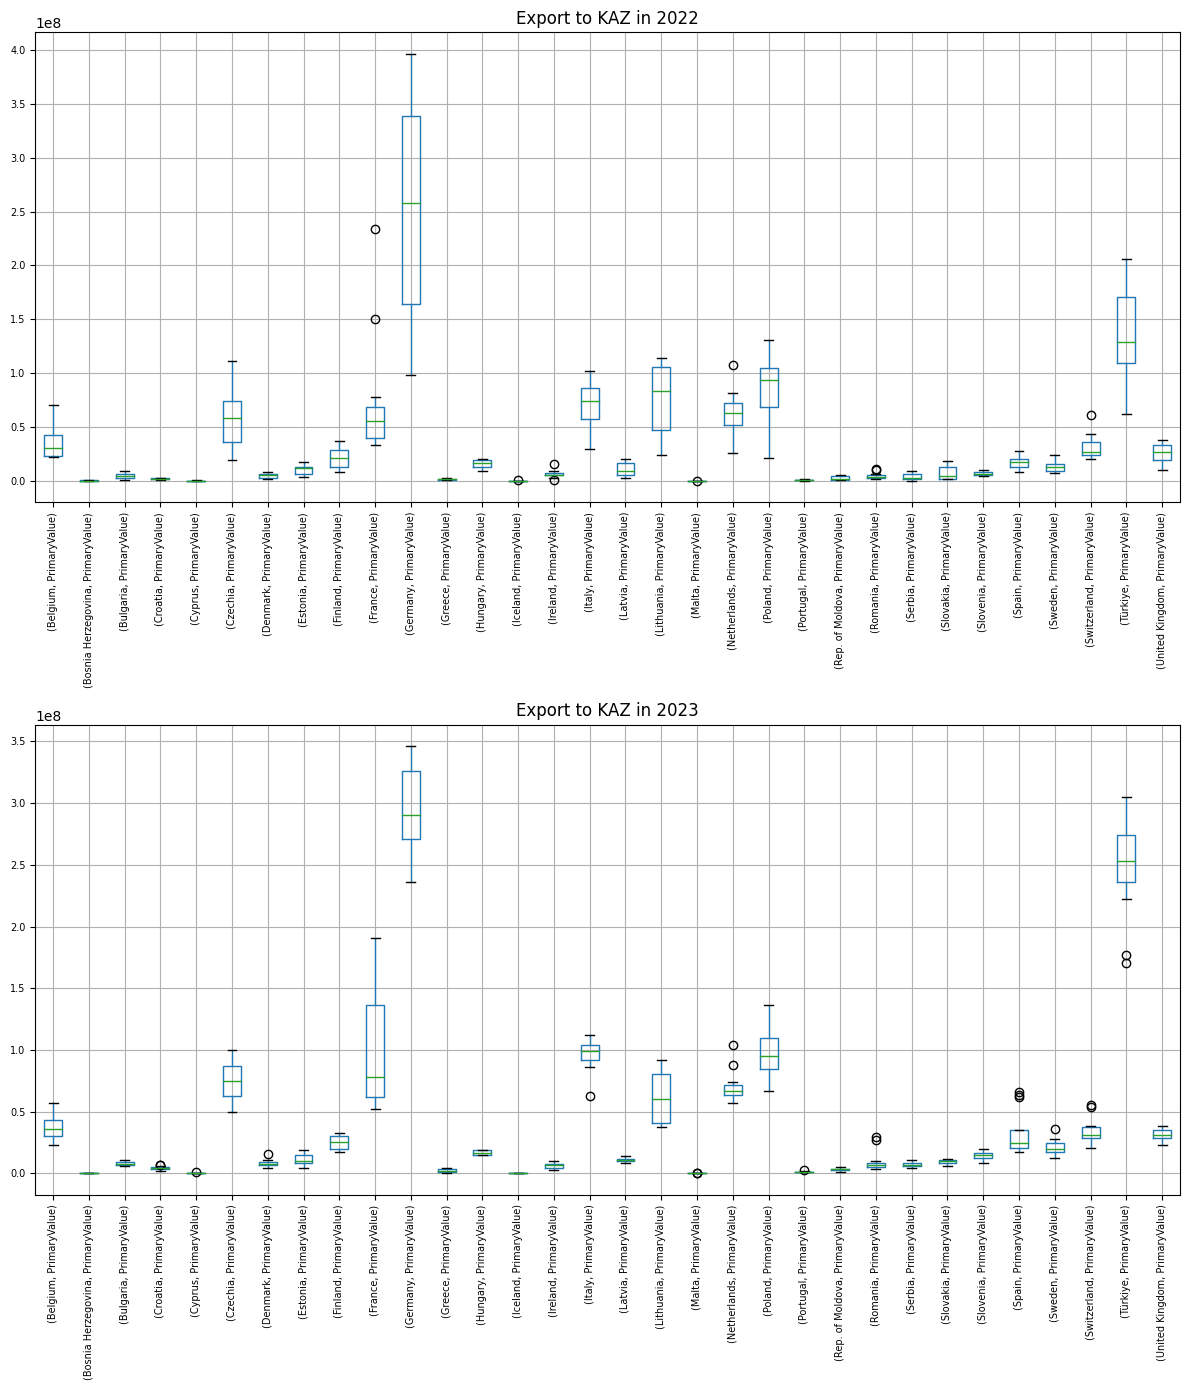

In [56]:
XPgroup_to_KAZ2 = X_to_KAZ2.groupby(by='ReporterDesc', sort=True)
XPgroup_to_KAZ3 = X_to_KAZ3.groupby(by='ReporterDesc', sort=True)
fig, axs = plt.subplots(nrows=2, figsize=(12, 14))

ax = XPgroup_to_KAZ2.boxplot(subplots=False, column=['PrimaryValue'], fontsize=7, rot=90, figsize=(12, 10), ax=axs[0])
ax = XPgroup_to_KAZ3.boxplot(subplots=False, column=['PrimaryValue'], fontsize=7, rot=90, figsize=(12, 10), ax=axs[1])

axs[0].set_title("Export to KAZ in 2022")
axs[1].set_title("Export to KAZ in 2023")
fig.tight_layout()
# а вы когда-нибудь задумывались что tight layout делает layout less tight? thank you for coming to my TED Talk
plt.show()

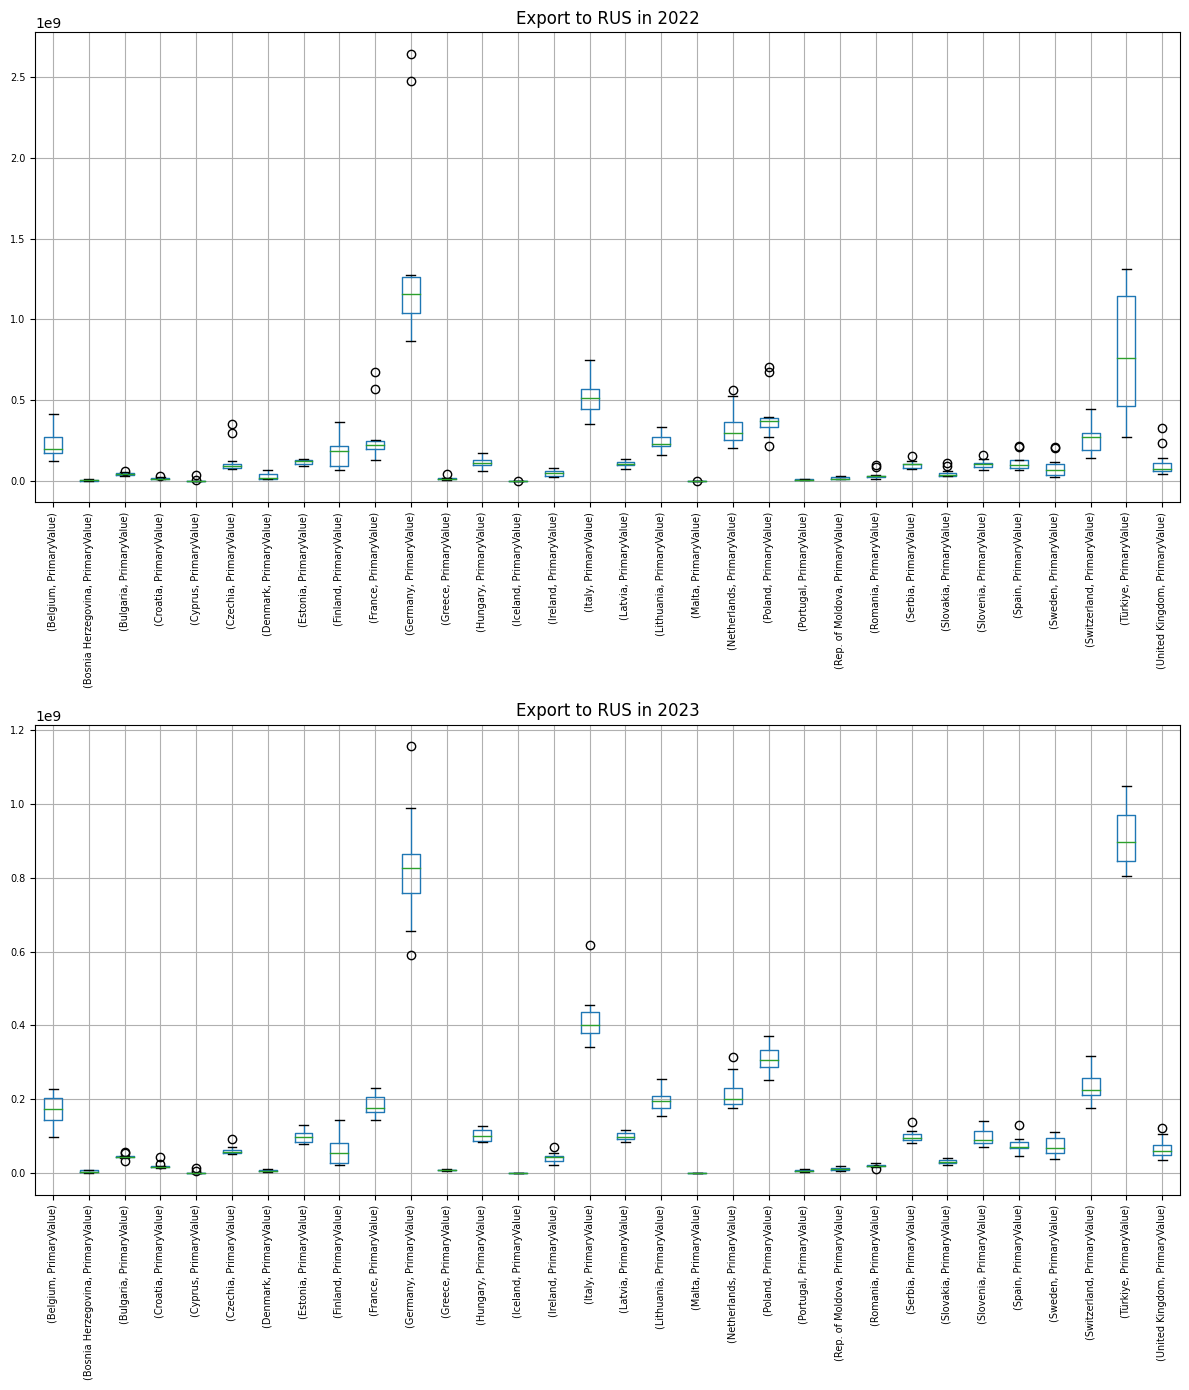

In [57]:
XPgroup_to_RUS2 = X_to_RUS2.groupby(by='ReporterDesc', sort=True)
XPgroup_to_RUS3 = X_to_RUS3.groupby(by='ReporterDesc', sort=True)
fig, axs = plt.subplots(nrows=2, figsize=(12, 14))
ax = XPgroup_to_RUS2.boxplot(subplots=False, column=['PrimaryValue'], fontsize=7, rot=90, figsize=(12, 10), ax=axs[0])
ax = XPgroup_to_RUS3.boxplot(subplots=False, column=['PrimaryValue'], fontsize=7, rot=90, figsize=(12, 10), ax=axs[1])

axs[0].set_title("Export to RUS in 2022")
axs[1].set_title("Export to RUS in 2023")
fig.tight_layout()

plt.show()

## Катимся в Кыргызстан, rolling даже на роликах

Для России и Кыргызстана подойдем с другой стороны. Boxplots, хоть и представленные двумя годами, не так хорошо отражают тенденции. Возьмем чистые данные, нарисуем график для каждой страны.

Т.к. месяц -- период маленький, будем брать скользящее среднее за два (за три оно было слишком гладким и теряло свой signature drop в экспорте в Россию в марте 2022, а без скользящего -- было слишком хаотичным)

Также в самой визуализации я ограничила до трех значений доли экспорта от среднего  -- они очевидно являются краткосрочными выбросами (по построению среднего) и тренд без них видно лучше.

/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:1477: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(y))
/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:758: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posy = float(self.convert_yunits(self._y))
/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:898: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(self._y))


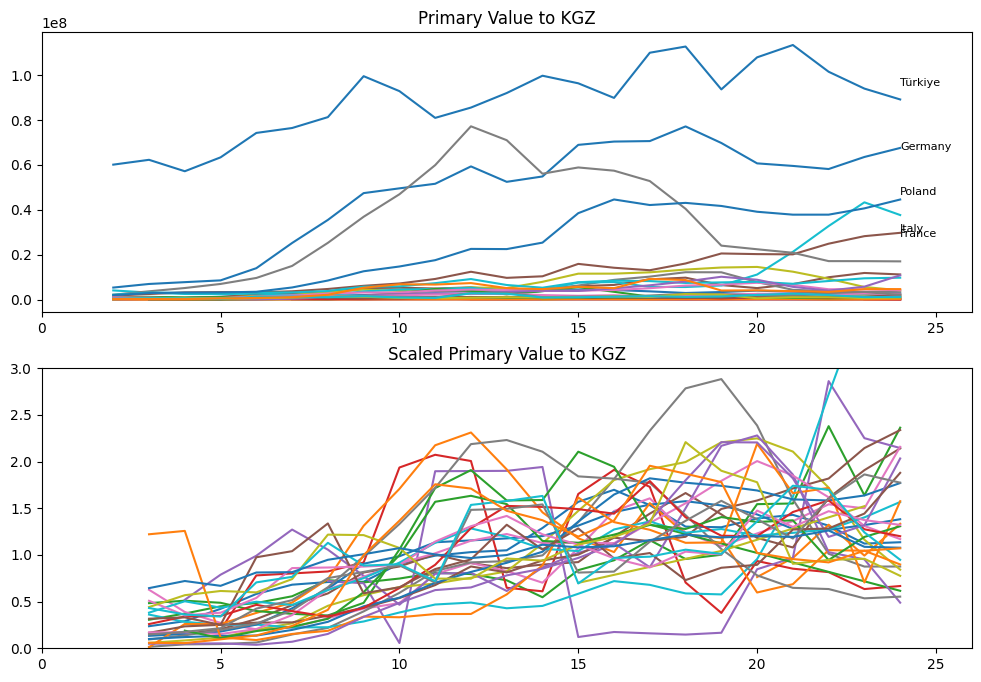

In [58]:
XPgroup_to_KGZ = XP_to_KGZ.groupby(by='ReporterDesc')

fig, axs = plt.subplots(nrows=2, figsize=(12, 8))
for i in XPgroup_to_KGZ.groups:
  axs[0].plot(XPgroup_to_KGZ.get_group(i)['Period'], XPgroup_to_KGZ.get_group(i)['PrimaryValue'].rolling(window=2).mean())
  label = i
  if label in ['Russia', 'Türkiye', 'France', 'Germany', 'Italy', 'Poland']:
    axs[0].annotate(label,
                    xy = (24, XPgroup_to_KGZ.get_group(i)['PrimaryValue'].tail(1)),
                    xytext = (24, XPgroup_to_KGZ.get_group(i)['PrimaryValue'].tail(1)), fontsize=8)

for i in XPgroup_to_KGZ.groups:
  avg = XPgroup_to_KGZ.get_group(i)['PrimaryValue'].mean()
  axs[1].plot(XPgroup_to_KGZ.get_group(i)['Period'], (XPgroup_to_KGZ.get_group(i)['PrimaryValue'].rolling(window=3).mean()/avg))

axs[0].set_title('Primary Value to KGZ')
axs[1].set_title('Scaled Primary Value to KGZ')
# scaling the plot itself
axs[0].set_xlim(0, 26)
axs[1].set_xlim(0, 26)
axs[1].set_ylim(0, 3)

plt.show()

/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:1477: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(y))
/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:758: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posy = float(self.convert_yunits(self._y))
/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:898: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(self._y))


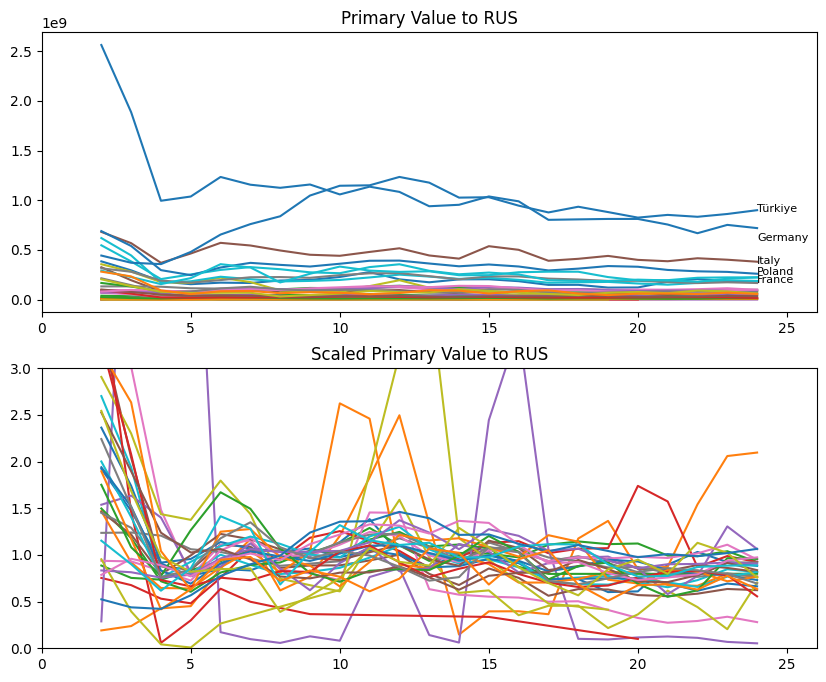

In [59]:
XPgroup_to_RUS = XP_to_RUS.groupby(by='ReporterDesc')

fig, axs = plt.subplots(nrows=2, figsize=(10, 8))
for i in XPgroup_to_RUS.groups:
  axs[0].plot(XPgroup_to_RUS.get_group(i)['Period'], XPgroup_to_RUS.get_group(i)['PrimaryValue'].rolling(window=2).mean())
  label = i
  if label in ['Russia', 'Türkiye', 'France', 'Germany', 'Italy', 'Poland']:
    axs[0].annotate(label,
                    xy = (24, XPgroup_to_RUS.get_group(i)['PrimaryValue'].tail(1)),
                    xytext = (24, XPgroup_to_RUS.get_group(i)['PrimaryValue'].tail(1)), fontsize=8)

for i in XPgroup_to_RUS.groups:
  avg = XPgroup_to_RUS.get_group(i)['PrimaryValue'].mean()
  axs[1].plot(XPgroup_to_RUS.get_group(i)['Period'], (XPgroup_to_RUS.get_group(i)['PrimaryValue'].rolling(window=2).mean()/avg))

axs[0].set_title('Primary Value to RUS')
axs[1].set_title('Scaled Primary Value to RUS')
# scaling the plot itself
axs[0].set_xlim(0, 26)
axs[1].set_xlim(0, 26)
axs[1].set_ylim(0, 3)

plt.show()

# Финальный босс визуализации -- scatter с линрег

Разумеется иронично, но иногда не нужно заново изобретать колесо. Если хочется посмотреть, какие конкретно страны *allegedly* увеличили экспорт в выбранные страны, который по итогу идет в Россию -- надо смотреть на их данные по отдельности. Ох, как мы насмотримся!

Забегая вперед, мы также собираем коэффициенты наклона наших регрессий для наглядного размещения на карте в финальной части проекта.

Графиков сейчас будет много, на каждой из строк представлен экспорт из одной страны в Кыргызстан, Казахстан и Россию соотвественно. Помните, мы переименовали периоды в числа от 1 до 24? Они и используются как данные для регрессии, а предсказываем мы общую сумму экспорта, деленную на среднее значение за два года.

In [60]:
XPgroup_to_KAZ = XP_to_KAZ.groupby(by='ReporterDesc')

coef_storageRUS = XPgroup_to_RUS['PrimaryValue'].mean()
coef_storageKAZ = XPgroup_to_KAZ['PrimaryValue'].mean()
coef_storageKGZ = XPgroup_to_KGZ['PrimaryValue'].mean()
# самый быстрый способ о котором я подумала

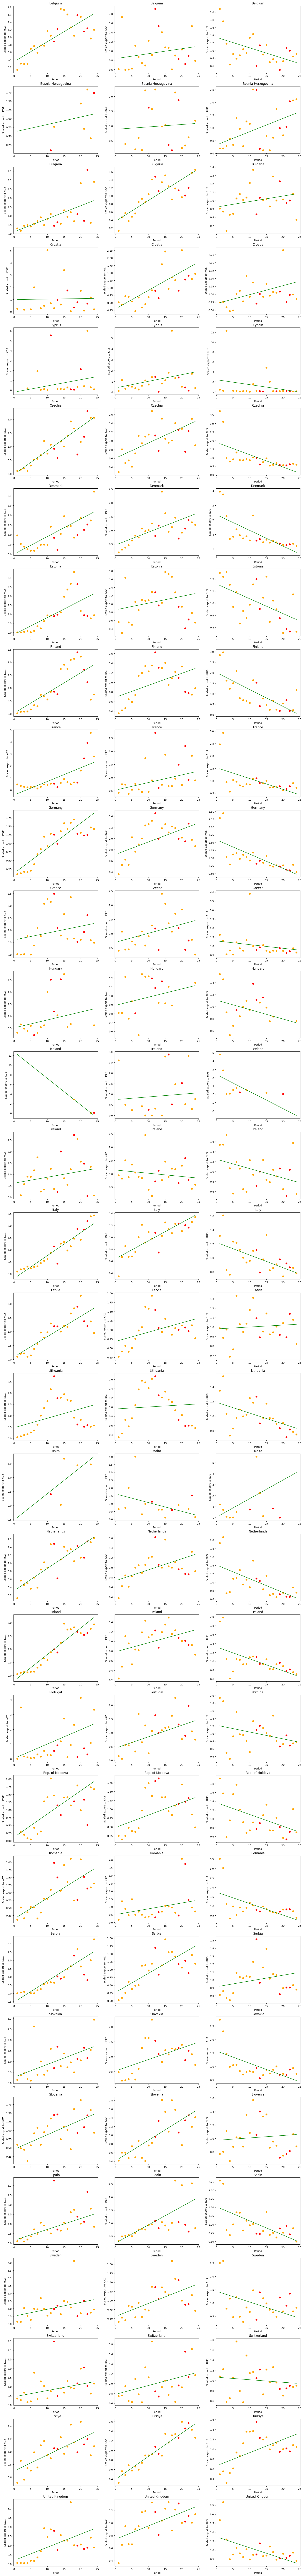

In [61]:
fig, axs = plt.subplots(nrows=len(full), ncols=3, figsize=(20, 180))
# reminder that full is the list of countries used
for i in range(len(full)):
  ## KGZ ##
  avg_KGZ = XPgroup_to_KGZ.get_group(full[i])['PrimaryValue'].mean()
  Y_total_KGZ = XPgroup_to_KGZ.get_group(full[i])['PrimaryValue']/avg_KGZ
  X_total_KGZ = pd.DataFrame(XPgroup_to_KGZ.get_group(full[i]), columns=['Period'])
  x_train_KGZ, x_test_KGZ, y_train_KGZ, y_test_KGZ = train_test_split(X_total_KGZ, Y_total_KGZ, test_size=0.2, random_state=340)
  LR = LinearRegression().fit(x_train_KGZ, y_train_KGZ)
  LR.predict(x_test_KGZ)
  x = range(1, 25)
  y_fin_KGZ = LR.coef_* x + LR.intercept_

  # вспоминаем про сбор коэффициентов наклона
  coef_storageKGZ.loc[full[i]] = LR.coef_[0]

  axs[i, 0].plot(x, y_fin_KGZ, color="green")
  axs[i, 0].scatter(x_test_KGZ, y_test_KGZ, color="red")
  axs[i, 0].scatter(x_train_KGZ, y_train_KGZ, color="orange")
  axs[i, 0].set_xlabel('Period')
  axs[i, 0].set_ylabel('Scaled export to KGZ')
  axs[i, 0].set_title(full[i])

  ## KAZ ##
  avg_KAZ = XPgroup_to_KAZ.get_group(full[i])['PrimaryValue'].mean()
  Y_total_KAZ = XPgroup_to_KAZ.get_group(full[i])['PrimaryValue']/avg_KAZ
  X_total_KAZ = pd.DataFrame(XPgroup_to_KAZ.get_group(full[i]), columns=['Period'])
  x_train_KAZ, x_test_KAZ, y_train_KAZ, y_test_KAZ = train_test_split(X_total_KAZ, Y_total_KAZ, test_size=0.2, random_state=340)
  LR = LinearRegression().fit(x_train_KAZ, y_train_KAZ)
  LR.predict(x_test_KAZ)

  y_fin_KAZ = LR.coef_* x + LR.intercept_

  # вспоминаем про сбор коэффициентов наклона
  coef_storageKAZ.loc[full[i]] = LR.coef_[0]

  axs[i, 1].plot(x, y_fin_KAZ, color="green")
  axs[i, 1].scatter(x_test_KAZ, y_test_KAZ, color="red")
  axs[i, 1].scatter(x_train_KAZ, y_train_KAZ, color="orange")
  axs[i, 1].set_xlabel('Period')
  axs[i, 1].set_ylabel('Scaled export to KAZ')
  axs[i, 1].set_title(full[i])

  ## RUS ##
  avg_RUS = XPgroup_to_RUS.get_group(full[i])['PrimaryValue'].mean()
  Y_total_RUS = XPgroup_to_RUS.get_group(full[i])['PrimaryValue']/avg_RUS
  X_total_RUS = pd.DataFrame(XPgroup_to_RUS.get_group(full[i]), columns=['Period'])
  x_train_RUS, x_test_RUS, y_train_RUS, y_test_RUS = train_test_split(X_total_RUS, Y_total_RUS, test_size=0.2, random_state=340)
  LR = LinearRegression().fit(x_train_RUS, y_train_RUS)
  LR.predict(x_test_RUS)

  y_fin_RUS = LR.coef_* x + LR.intercept_

  # вспоминаем про сбор коэффициентов наклона
  coef_storageRUS.loc[full[i]] = LR.coef_[0]

  axs[i, 2].plot(x, y_fin_RUS, color="green")
  axs[i, 2].scatter(x_test_RUS, y_test_RUS, color="red")
  axs[i, 2].scatter(x_train_RUS, y_train_RUS, color="orange")
  axs[i, 2].set_xlabel('Period')
  axs[i, 2].set_ylabel('Scaled export to RUS')
  axs[i, 2].set_title(full[i])

plt.show()

# Время карт
Финишная прямая -- sneak-peak этих карт вы могли заметить в самом начале проекта. Будем использовать один из геодатасетов Фолиума (вы только посмотрите на эти полигоны!) и также собранные в предыдущей части коэффициенты.

Для начала -- необходимо согласование названий стран в earth и нашем array индексов. Т.к. id в этом датасете у стран нет, обращаться к ним будем по имени (без отчества, через feature.properties.name).

Надо посмотреть, какие страны названы по разному и не получают необходимых параметров.

In [63]:
earth = requests.get(
    "https://raw.githubusercontent.com/python-visualization/folium-example-data/main/world_countries.json"
    ).json()

In [64]:
earth_list = []
for i in earth['features']:
  earth_list.append(i['properties']['name'])
for i in coef_storageKGZ.index:
  if i not in earth_list:
    print(i)

Bosnia Herzegovina
Czechia
Malta
Rep. of Moldova
Serbia
Türkiye


Culprits найдены. Давайте создавать коэффициенты с правильными индексами (на неправильные дупликаты можно забить)

In [65]:
for i in (coef_storageKGZ, coef_storageKAZ, coef_storageRUS):
  i['Bosnia and Herzegovina'] = i['Bosnia Herzegovina']
  i['Czech Republic'] = i['Czechia']
  # на i['Malta'] смотреть не будем -- полигонов не хватило :(
  i['Moldova'] = i['Rep. of Moldova']
  i['Republic of Serbia'] = i['Serbia']
  i['Turkey'] = i['Türkiye']

## Карта динамики экспорта в Казахстан

In [66]:
m_x_to_KAZ = folium.Map([50, 40], zoom_start=4)

folium.Choropleth(
    geo_data = earth,
    data = coef_storageKAZ,
    fill_opacity = 0.8,
    line_weight = 2,
    key_on = "feature.properties.name",
    fill_color = "PRGn",
    bins = [-0.5, -0.3, -0.1, -0.05, 0, 0.05, 0.1, 0.3, 0.5],
).add_to(m_x_to_KAZ)

m_x_to_KAZ

## Карта динамики экспорта в Кыргызстан

In [67]:
m_x_to_KGZ = folium.Map([50, 40], zoom_start=4)

folium.Choropleth(
    geo_data = earth,
    data = coef_storageKGZ,
    fill_opacity = 0.8,
    line_weight = 2,
    key_on = "feature.properties.name",
    fill_color = "PRGn",
    bins = [-0.6, -0.3, -0.1, -0.05, 0, 0.05, 0.1, 0.3, 0.6],
).add_to(m_x_to_KGZ)

m_x_to_KGZ

## Карта динамики экспорта в Россию

In [68]:
m_x_to_RUS = folium.Map([50, 40], zoom_start=4)

folium.Choropleth(
    geo_data = earth,
    data = coef_storageRUS,
    fill_opacity = 0.8,
    line_weight = 2,
    key_on = "feature.properties.name",
    fill_color = "PRGn",
    bins = [-0.5, -0.3, -0.1, -0.05, 0, 0.05, 0.1, 0.3, 0.5],
).add_to(m_x_to_RUS)

m_x_to_RUS

# Заключение

Как можно было догадаться к концу проекта, меня очень интересовала судьба моих острых Pringles из Вкусвилла. Но придти вышло к чему-то большему -- импорт обоих выбранных строн вырос после февраля 2022 -- и местами даже продолжает расти!

Говоря о показательных осуждениях действий стран, важно помнить, что место для дополнительной прибыли найдется всегда. Дочерние компании переименовываются, заводы в нежелательных странах перепродаются новым фирмам, прямые экспорты принимают более извилистые тропинки.

Да, описанные выше *лазейки* все равно не дадут фирмам и странам предыдущей прибыли (а нам -- предыдущего качества жизни), но стоит помнить, что моральные и репутационные издержки в balance sheet компаний всегда будут указаны в деньгах.